## Problem statement

## Business Objectives 

* Learn from data and and build a recommender that recommends best TV shows to users, based on self & others behaviour
* Predict the rating that a user would give to a movie that he has not yet rated.
* Minimize the difference between predicted and actual rating (RMSE and MAPE).

# Data Selection

The dataset used in this project comes directly from Netflix. The data was used in the Netflix Prize open competition for the best algorithm to predict user ratings for films. 

Firstly,the data was loaded into the notebook and the scope, type and properties of the data was examined. 

The documentation attached to the data includes the following descriptions of the data files:


**Type of Data:**
* There are 17770 unique movie IDs.
* There are 480189 unique user IDs.
* There are ratings. Ratings are on a five star (integral) scale from 1 to 5.

**Data Overview**

**Training data:**

* combined_data_1.txt
* combined_data_2.txt
* combined_data_3.txt
* combined_data_4.txt

The first line of each file contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format: **<CustomerID,Rating,Date>**

**Movies file description:**
* movie_titles.csv contains movie information in the following format: **<MovieID,YearOfRelease,Title>**
* **MovieID** do not correspond to actual Netflix movie id or IMDB movie id
* **YearOfRelease**  can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release.
* **Title** is the Netflix movie title and may not correspond to titles used on other sites.
* **Titles** are in English.

# Data Preprocessing and Transformation

### 1. Reading and storing the data

In [1]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# Libraries for visualisations in the notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
import re
import os
from datetime import datetime

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import math

# utils import
from fuzzywuzzy import fuzz

import matplotlib.dates as dates
import matplotlib.dates as mdates

/usr/local/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Loading Rating Data


In the following projekt the Kaggle Netflix Prize data is used. <a name="ref-1"/>[[1]](#netflix-prize)
There are multiple data files for different purposes. The following data files are used in this project:

**Training data:**

* combined_data_1.txt
* combined_data_2.txt
* combined_data_3.txt
* combined_data_4.txt

**Movie titles data file:**
* movie_titles.csv





In [2]:
def readFile(file_path, rows=10000):
    data_dict = {'Cust_ID' : [], 'Movie_ID' : [], 'Rating' : [], 'Date' : []}
    f = open(file_path, "r")
    count = 0
    for line in f:
        count += 1
        if count > rows:
             break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_ID'].append(customerID)
            data_dict['Movie_ID'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    f.close()
            
    return pd.DataFrame(data_dict)

In [3]:
# Records from each training data file is loaded into memory as Panda DataFrame as follows:

df1 = readFile('./data/Netflix_prize_data/combined_data_1.txt')
df2 = readFile('./data/Netflix_prize_data/combined_data_2.txt')
df3 = readFile('./data/Netflix_prize_data/combined_data_3.txt')
df4 = readFile('./data/Netflix_prize_data/combined_data_4.txt')

In [4]:
# Combine the different DataFrames of training data into one as follows:

df_ratings=df1.copy()
df_ratings=df_ratings.append(df2)
df_ratings=df_ratings.append(df3)
df_ratings=df_ratings.append(df4)


In [5]:
# Check the columns types
df_ratings.dtypes

Cust_ID     object
Movie_ID     int64
Rating      object
Date        object
dtype: object

In [6]:
# Change type of some columns 
df_ratings['Rating'] = df_ratings['Rating'].astype(float)

df_ratings["Date"] = pd.to_datetime(df_ratings["Date"])
#df.sort_values(by = "Date", inplace = True)

In [7]:
# Basic statistics of Rating  column
df_ratings['Rating'].describe()

count    39967.000000
mean         3.543523
std          1.172506
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: Rating, dtype: float64

In [8]:
# Check the dimension of the DataFrame
print ("Dimension: "+ str (df_ratings.shape))
print ("Number of rows: "+ str (df_ratings.shape[0]) )
print ("Number of columns: "+ str (df_ratings.shape[1]) )

Dimension: (39967, 4)
Number of rows: 39967
Number of columns: 4


### Data cleaning

In this step, the primary focus is on handling missing data, noisy data, detection, and removal of outliers, minimizing duplication and computed biases within the data.

#### Checking for missings

In [9]:
print("Number of NaN values = "+str(df_ratings.isnull().sum()))

Number of NaN values = Cust_ID     0
Movie_ID    0
Rating      0
Date        0
dtype: int64


In [10]:
# Check for missings
print(len(df_ratings.columns[df_ratings.isna().any()])/len(df_ratings.columns))
print(df_ratings.isnull().sum().sum()/np.product(df_ratings.shape))

0.0
0.0


#### Checking for duplicates 

In [11]:
# Check for duplicates
duplicates = df_ratings.duplicated(["Cust_ID", "Movie_ID", "Rating"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


In [12]:
# Splitting the Date column into year and month 
df_ratings['year'] = pd.DatetimeIndex(df_ratings['Date']).year
df_ratings['month'] = pd.DatetimeIndex(df_ratings['Date']).month

In [13]:
df_ratings.head()

,Cust_ID,Movie_ID,Rating,Date,year,month
0,1488844,1,3.0,2005-09-06,2005,9
1,822109,1,5.0,2005-05-13,2005,5
2,885013,1,4.0,2005-10-19,2005,10
3,30878,1,4.0,2005-12-26,2005,12
4,823519,1,3.0,2004-05-03,2004,5


# Loading Movie Data 

To read the file correctly, you should pass the encoding that the file was written. We also want to give the columns names:

In [14]:
df_movies = pd.read_csv('./data/Netflix_prize_data/movie_titles.csv',
                              encoding = "ISO-8859-1",   # movie_titles.csv: text/plain; charset=iso-8859-1
                              header = None,
                              names= ['Movie_ID', 'YearOfRelease','Movie'])      
df_movies.head()

,Movie_ID,YearOfRelease,Movie
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [15]:
# Checking the data type
df_movies.dtypes

Movie_ID           int64
YearOfRelease    float64
Movie             object
dtype: object

In [16]:
df_movies.shape

(17770, 3)

In [17]:
# in order to convert non-finite values (NA or inf) to int
df_movies = df_movies.fillna(0)
df_movies['YearOfRelease']=df_movies['YearOfRelease'].astype(int)
df_movies.head ()

,Movie_ID,YearOfRelease,Movie
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [18]:
movies_per_year = df_movies.groupby('YearOfRelease')['Movie'].count().sort_values()
movies_per_year

YearOfRelease
1896       1
1909       1
1914       2
1918       2
1923       2
        ... 
2001    1184
2000    1234
2003    1271
2002    1310
2004    1436
Name: Movie, Length: 95, dtype: int64

## Data cleaning

#### Checking for missings

In [19]:
print("Number of NaN values = "+str(df_movies.isnull().sum()))

Number of NaN values = Movie_ID         0
YearOfRelease    0
Movie            0
dtype: int64


In [20]:
print(len(df_movies.columns[df_movies.isna().any()])/len(df_movies.columns))
print(df_movies.isnull().sum().sum()/np.product(df_movies.shape))

0.0
0.0


#### Checking for duplicates

In [21]:
# Check for duplicates
duplicates = df_movies.duplicated(["Movie_ID", "Movie"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


In [22]:
# Combine all dataframes
df_final = df_ratings.join(df_movies.set_index('Movie_ID'),on="Movie_ID")
df_final

,Cust_ID,Movie_ID,Rating,Date,year,month,YearOfRelease,Movie
0,1488844,1,3.0,2005-09-06,2005,9,2003,Dinosaur Planet
1,822109,1,5.0,2005-05-13,2005,5,2003,Dinosaur Planet
2,885013,1,4.0,2005-10-19,2005,10,2003,Dinosaur Planet
3,30878,1,4.0,2005-12-26,2005,12,2003,Dinosaur Planet
4,823519,1,3.0,2004-05-03,2004,5,2003,Dinosaur Planet
...,...,...,...,...,...,...,...,...
9984,628670,13378,3.0,2004-09-26,2004,9,1940,His Girl Friday
9985,699305,13378,5.0,2004-10-04,2004,10,1940,His Girl Friday
9986,2468329,13378,2.0,2004-10-20,2004,10,1940,His Girl Friday
9987,1762173,13378,4.0,2004-10-27,2004,10,1940,His Girl Friday


In [23]:
df_final.to_csv (r'./data/Netflix_prize_data/df_final.csv', index = False, header=True)

In [24]:
#df_final.index = np.arange(0,len(df_final))
#df_final.head(10)

# Exploring Data

## Basic statistic

In [25]:
rating_data=str(df_ratings.shape[0])
num_users=str(len(np.unique(df_ratings["Cust_ID"])))
num_mov = str(len(np.unique(df_ratings["Movie_ID"])))
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_mov))

There are 32800 unique users and 33 unique movies in this data set


In [26]:
print ("Ratings per year")
# Calculate the ratings per year
rating_per_year = df_final.groupby (by = 'year')["Rating"].count().sort_values(ascending = True)
#rating_per_year = df_ratings.groupby (by = 'year')["Rating"].count().sort_values(ascending = True)
rating_per_year

Ratings per year


year
1999        1
2000      344
2001      767
2002     1599
2003     3806
2004    10123
2005    23327
Name: Rating, dtype: int64

In [27]:
# Calculate the avarage rating per year
avg_rating_per_year= df_ratings.groupby (by= 'year')['Rating'].mean()
avg_rating_per_year

year
1999    3.000000
2000    3.093023
2001    3.410691
2002    3.108818
2003    3.387546
2004    3.582436
2005    3.592918
Name: Rating, dtype: float64

In [28]:
df_movies.head()

,Movie_ID,YearOfRelease,Movie
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [29]:
print ("Rated movies per year")
# Calculate the rated movies per year
movie_rated_per_year = df_final.groupby(by='YearOfRelease')['Movie_ID'].nunique().sort_values()
movie_rated_per_year

Rated movies per year


YearOfRelease
1933    1
1995    1
1989    1
1988    1
1985    1
1992    1
1961    1
1945    1
1940    1
1981    1
1963    2
1994    2
1996    2
1999    2
2001    2
2003    3
1997    3
2004    3
2002    4
Name: Movie_ID, dtype: int64

In [30]:
movie_rated_per_month = df_final.groupby(by='Date')['Movie'].count().sort_values()
movie_rated_per_month.head()

Date
1999-12-31    1
2002-03-30    1
2001-01-18    1
2001-01-17    1
2001-01-15    1
Name: Movie, dtype: int64

In [31]:
# for showing the data in Millions
def changingLabels(number):
    return str(number/10**6) + "M"

## Distribution of ratings

<ipython-input-32-19c5e15c4289>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


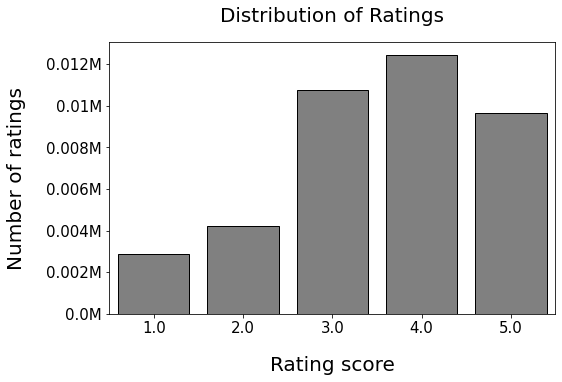

In [32]:
# Check the distribution of the ratings 
plt.figure(figsize = (8, 5))
#sns.set_palette("mako")
ax = sns.countplot(x="Rating", data=df_final,color='grey',  edgecolor='black')

# for showing the data in Millions
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings", fontsize = 20, pad =20)
plt.xlabel("Rating score", fontsize = 20, labelpad = 20)
plt.ylabel("Number of ratings", fontsize = 20, labelpad = 20)
plt.show()

In [33]:
df_final["Date"] = pd.to_datetime(df_final["Date"])

# Analysis of Ratings given by user

In [34]:
df_final.head()

,Cust_ID,Movie_ID,Rating,Date,year,month,YearOfRelease,Movie
0,1488844,1,3.0,2005-09-06,2005,9,2003,Dinosaur Planet
1,822109,1,5.0,2005-05-13,2005,5,2003,Dinosaur Planet
2,885013,1,4.0,2005-10-19,2005,10,2003,Dinosaur Planet
3,30878,1,4.0,2005-12-26,2005,12,2003,Dinosaur Planet
4,823519,1,3.0,2004-05-03,2004,5,2003,Dinosaur Planet


In [35]:
print("Ratings per user")
# Get the ratings given by user
cnt_rating_per_user = df_final.groupby(by = "Cust_ID")["Movie_ID"].count().sort_values(ascending = False)
cnt_rating_per_user.head()

Ratings per user


Cust_ID
2439493    31
305344     29
387418     29
1664010    27
2118461    26
Name: Movie_ID, dtype: int64

In [36]:
cnt_rating_per_user.describe()

count    32800.000000
mean         1.218506
std          0.709849
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         31.000000
Name: Movie_ID, dtype: float64

In [37]:
print("Users with highest number of ratings")
cnt_rating_per_user_20 = cnt_rating_per_user[:20]
cnt_rating_per_user_20

Users with highest number of ratings


Cust_ID
2439493    31
305344     29
387418     29
1664010    27
2118461    26
1639792    18
1461435    16
1932594    15
727242     15
2606799    14
1314869    13
1784150    11
2147527    11
798296     11
1001129    10
525356     10
636262     10
1403217    10
491531     10
1792741    10
Name: Movie_ID, dtype: int64

In [38]:
print("Users with lowest number of ratings")
cnt_rating_per_user_last_20 = cnt_rating_per_user[-20:]
cnt_rating_per_user_last_20

Users with lowest number of ratings


Cust_ID
1860023    1
1859762    1
185973     1
1859418    1
1859319    1
1859288    1
1859215    1
1859064    1
1859041    1
1858964    1
1858927    1
1858921    1
1858847    1
1858770    1
1858626    1
1858601    1
1858464    1
1858421    1
1858316    1
999901     1
Name: Movie_ID, dtype: int64

In [39]:
sns.set_palette("mako")

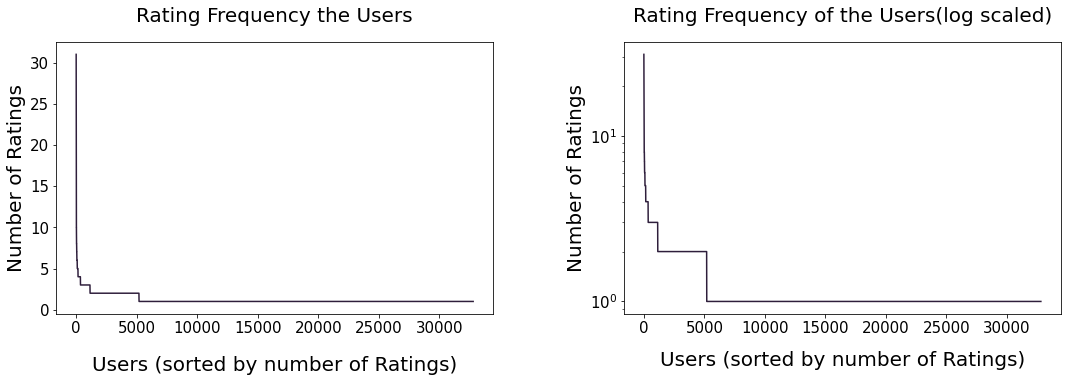

In [70]:
# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

sns.set_palette("mako")

# plot rating frequency of all movies
cnt_rating_per_user.reset_index(drop=True).plot(ax=ax1); # reset_index(drop=True)

# Add title and labels
ax1.set_title("Rating Frequency the Users",fontsize = 20,pad =20); #distance between title 
ax1.set_xlabel("Users (sorted by number of Ratings)",fontsize = 20, labelpad=20)
ax1.set_ylabel("Number of Ratings",fontsize = 20)
#ax1.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

# plot rating frequency of all movies in log scale
cnt_rating_per_user.reset_index(drop=True).plot(logy = True, ax=ax2);

# Add title and labels 
ax2.set_title("Rating Frequency of the Users(log scaled)",fontsize = 20, pad =20);
ax2.set_xlabel("Users (sorted by number of Ratings)",fontsize = 20, labelpad=15) #fontdict=dict(weight='bold')
ax2.set_ylabel("Number of Ratings",fontsize = 20)

fig.subplots_adjust(wspace=0.3) #the amount of width reserved for space between subplots,
# Remove empty white space around the plot

# change the fontsize of minor ticks label 
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

plt.show()


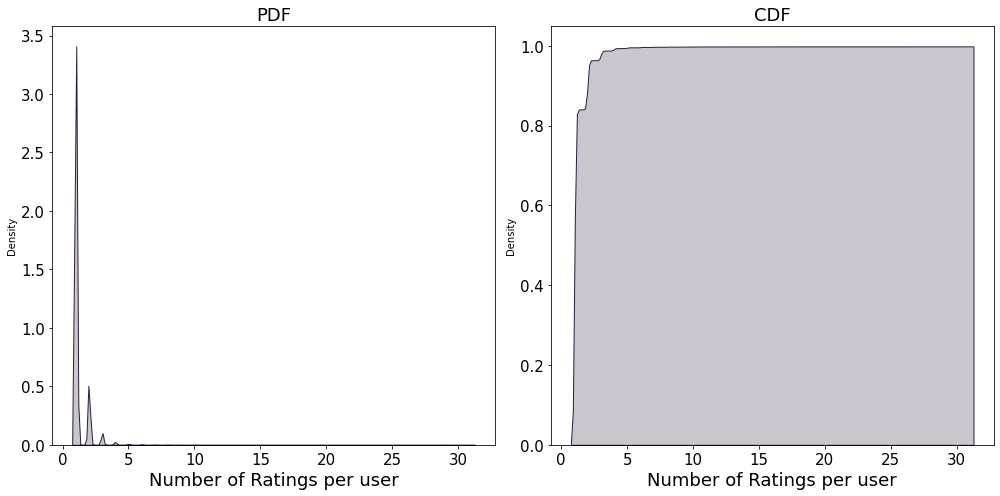

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

# Generate the probability density function (PDF)
sns.kdeplot(cnt_rating_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings per user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

# Generate the cumulative distribution (CDF)
sns.kdeplot(cnt_rating_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings per user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [42]:
df_final.head()

,Cust_ID,Movie_ID,Rating,Date,year,month,YearOfRelease,Movie
0,1488844,1,3.0,2005-09-06,2005,9,2003,Dinosaur Planet
1,822109,1,5.0,2005-05-13,2005,5,2003,Dinosaur Planet
2,885013,1,4.0,2005-10-19,2005,10,2003,Dinosaur Planet
3,30878,1,4.0,2005-12-26,2005,12,2003,Dinosaur Planet
4,823519,1,3.0,2004-05-03,2004,5,2003,Dinosaur Planet


In [43]:
cnt_user_ratings_per_year = df_final.groupby(by = "year")["Rating"].count().sort_values(ascending = False)

In [44]:
print("User ratings per year:")
cnt_user_ratings_per_year

User ratings per year:


year
2005    23327
2004    10123
2003     3806
2002     1599
2001      767
2000      344
1999        1
Name: Rating, dtype: int64

In [45]:
cnt_user_ratings_per_year.describe()

count        7.000000
mean      5709.571429
std       8526.221122
min          1.000000
25%        555.500000
50%       1599.000000
75%       6964.500000
max      23327.000000
Name: Rating, dtype: float64

<ipython-input-46-6f7dcc70d416>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


[Text(0, -5000.0, '-0.005M'),
 Text(0, 0.0, '0.0M'),
 Text(0, 5000.0, '0.005M'),
 Text(0, 10000.0, '0.01M'),
 Text(0, 15000.0, '0.015M'),
 Text(0, 20000.0, '0.02M'),
 Text(0, 25000.0, '0.025M')]

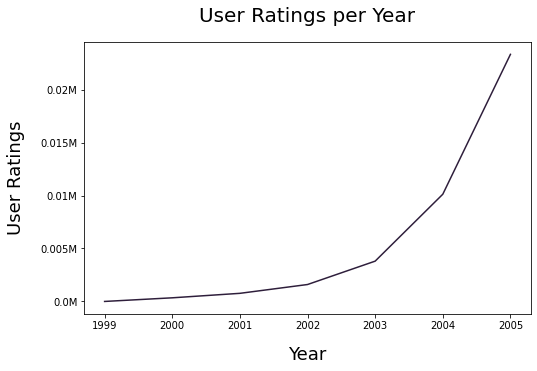

In [46]:
plt.figure(figsize = (8,5))
ax=cnt_user_ratings_per_year.plot()
ax.set_title("User Ratings per Year",fontsize = 20,pad =20)
ax.set_xlabel("Year",fontsize = 18, labelpad=15)
ax.set_ylabel("User Ratings",fontsize = 18, labelpad=15)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

<ipython-input-47-e58f6fa2299f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


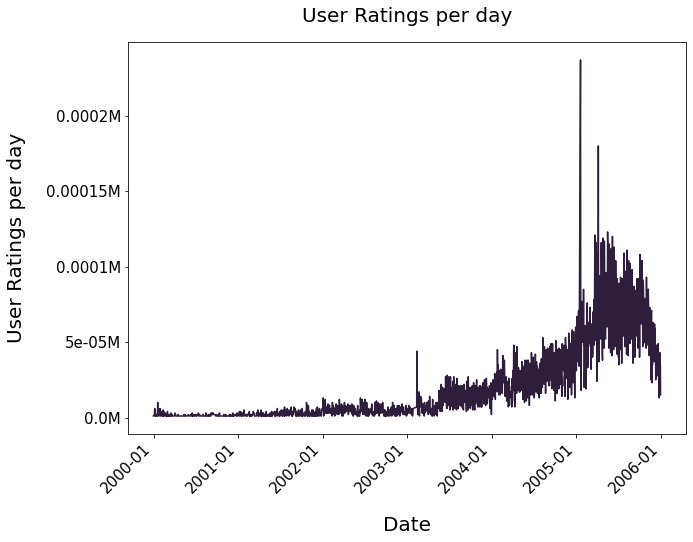

In [47]:
plt.figure(figsize = (10,8))
ax = df_final.groupby(by = "Date")["Rating"].count().plot()
ax.set_title("User Ratings per day", fontsize = 20, pad =20)
ax.set_xlabel("Date", fontsize = 20,labelpad=20)
ax.set_ylabel("User Ratings per day", fontsize = 20,labelpad=20)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
ax.xaxis.set_major_formatter(mdates.DateFormatter ("%Y-%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter ("%Y-%m"))
_=plt.xticks(rotation=45)
plt.show()

In [48]:
print ("Avarage User rating per year")
cnt_user_ratings_per_year = df_final.groupby(by = "year")["Rating"].mean().sort_values(ascending = False)
cnt_user_ratings_per_year

Avarage User rating per year


year
2005    3.592918
2004    3.582436
2001    3.410691
2003    3.387546
2002    3.108818
2000    3.093023
1999    3.000000
Name: Rating, dtype: float64

In [49]:
cnt_user_ratings_per_year.describe()

count    7.000000
mean     3.310776
std      0.242921
min      3.000000
25%      3.100921
50%      3.387546
75%      3.496564
max      3.592918
Name: Rating, dtype: float64

In [50]:
df_final.head()

,Cust_ID,Movie_ID,Rating,Date,year,month,YearOfRelease,Movie
0,1488844,1,3.0,2005-09-06,2005,9,2003,Dinosaur Planet
1,822109,1,5.0,2005-05-13,2005,5,2003,Dinosaur Planet
2,885013,1,4.0,2005-10-19,2005,10,2003,Dinosaur Planet
3,30878,1,4.0,2005-12-26,2005,12,2003,Dinosaur Planet
4,823519,1,3.0,2004-05-03,2004,5,2003,Dinosaur Planet


In [51]:
print("Raters per year:")
cnt_raters_per_year = df_final.groupby(by='year')['Cust_ID'].nunique().sort_values()
cnt_raters_per_year

Raters per year:


year
1999        1
2000      322
2001      652
2002     1445
2003     3393
2004     9009
2005    20444
Name: Cust_ID, dtype: int64

In [52]:
cnt_raters_per_year.describe()

count        7.000000
mean      5038.000000
std       7478.618099
min          1.000000
25%        487.000000
50%       1445.000000
75%       6201.000000
max      20444.000000
Name: Cust_ID, dtype: float64

# Analysis of ratings pro Movie

## Plot rating frequency of all movies

In [53]:
df_movies.head()

,Movie_ID,YearOfRelease,Movie
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [54]:
print("Released movies per year")
cnt_movies_rel_year =df_movies.groupby('YearOfRelease')['Movie_ID'].count().sort_values(ascending =False)
cnt_movies_rel_year

Released movies per year


YearOfRelease
2004    1436
2002    1310
2003    1271
2000    1234
2001    1184
        ... 
1923       2
1918       2
1914       2
1909       1
1896       1
Name: Movie_ID, Length: 95, dtype: int64

In [55]:
print("Ratings per Movie:")
# get rating frequency
cnt_ratings_per_movie = pd.DataFrame(df_final.groupby('Movie_ID')['Rating'].count()
                                     .sort_values(ascending =False))

cnt_ratings_per_movie.sort_values(by='Movie_ID').head()

Ratings per Movie:


,Rating
Movie_ID,
1,547
2,145
3,2012
4,142
5,1140


In [56]:
print("Movies with highest number of ratings")
cnt_ratings_per_movie_20 = cnt_ratings_per_movie[:20]
cnt_ratings_per_movie_20

Movies with highest number of ratings


,Rating
Movie_ID,
9217,7439
4506,6843
8,4894
13370,2715
13378,2662
3,2012
4503,1779
13375,1157
5,1140


In [57]:
print("Movies with lowest number of ratings")
cnt_ratings_per_movie_last_20 = cnt_ratings_per_movie[-20:]
cnt_ratings_per_movie_last_20

Movies with lowest number of ratings


,Rating
Movie_ID,
4501,595
1,547
13368,527
9211,504
9215,375
9214,364
13372,358
9216,327
13373,286


<ipython-input-69-4a36c0957bb2>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


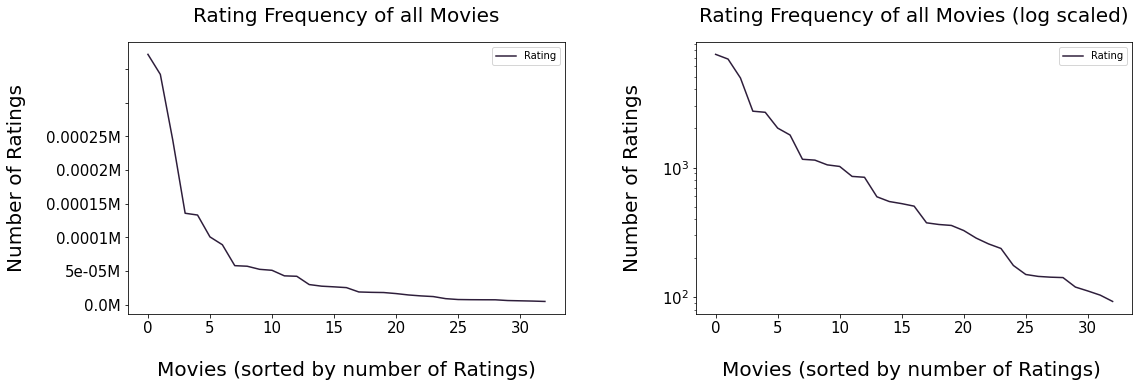

In [69]:
# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# plot rating frequency of all movies
cnt_ratings_per_movie.reset_index(drop=True).plot(ax=ax1); 
# Add title and labels
ax1.set_title("Rating Frequency of all Movies",fontsize = 20,pad =20); #distance between title 
ax1.set_xlabel("Movies (sorted by number of Ratings)",fontsize = 20, labelpad =25)
ax1.set_ylabel("Number of Ratings",fontsize = 20, labelpad =20)
ax1.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

# plot rating frequency of all movies in log scale
cnt_ratings_per_movie.reset_index(drop=True).plot(logy = True, ax=ax2);

# Add title and labels 
ax2.set_title("Rating Frequency of all Movies (log scaled)",fontsize = 20, pad =20);
ax2.set_xlabel("Movies (sorted by number of Ratings) ",fontsize = 20, labelpad=25) #fontdict=dict(weight='bold')
ax2.set_ylabel("Number of Ratings",fontsize = 20,labelpad=20)

fig.subplots_adjust(wspace=0.3) #the amount of width reserved for space between subplots,
# Remove empty white space around the plot
#plt.tight_layout()

# change the fontsize of minor ticks label 
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
plt.show()


The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

We can see that roughly X out of Y movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [59]:
quantiles=cnt_ratings_per_movie['Rating'].quantile(np.arange(0,1.01,0.01))

In [60]:
quantiles[::5]

0.00      93.0
0.05     108.8
0.10     124.4
0.15     142.8
0.20     147.0
0.25     176.0
0.30     250.0
0.35     294.2
0.40     351.8
0.45     368.4
0.50     504.0
0.55     539.0
0.60     644.2
0.65     851.4
0.70    1030.6
0.75    1140.0
0.80    1530.2
0.85    2142.0
0.90    2704.4
0.95    5673.6
1.00    7439.0
Name: Rating, dtype: float64

In [61]:
df_final["WeekDay"] = df_final.Date.dt.day_name()
df_final["Month"] = df_final.Date.dt.month_name()

In [62]:
df_final.head()

,Cust_ID,Movie_ID,Rating,Date,year,month,YearOfRelease,Movie,WeekDay,Month
0,1488844,1,3.0,2005-09-06,2005,9,2003,Dinosaur Planet,Tuesday,September
1,822109,1,5.0,2005-05-13,2005,5,2003,Dinosaur Planet,Friday,May
2,885013,1,4.0,2005-10-19,2005,10,2003,Dinosaur Planet,Wednesday,October
3,30878,1,4.0,2005-12-26,2005,12,2003,Dinosaur Planet,Monday,December
4,823519,1,3.0,2004-05-03,2004,5,2003,Dinosaur Planet,Monday,May


In [63]:
print("Cumulative User Ratings for days of the week")
cnt_ratings_per_day = df_final.groupby('WeekDay')['Rating'].count().sort_values()
cnt_ratings_per_day

Cumulative User Ratings for days of the week


WeekDay
Saturday     3892
Sunday       4296
Friday       5395
Thursday     5709
Wednesday    6540
Tuesday      7009
Monday       7126
Name: Rating, dtype: int64

<ipython-input-64-e8f0f2955eb0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


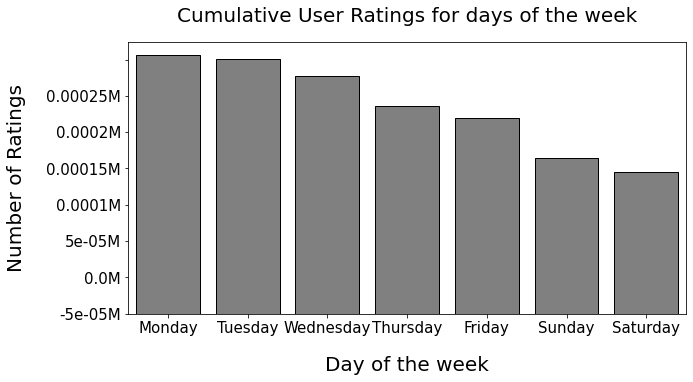

In [64]:
fig = plt.figure(figsize = (10, 5))

axes = sns.countplot(x = "WeekDay", data = df_final,order=df_final['WeekDay'].value_counts().index, color='grey',  edgecolor='black')
axes.set_title("Cumulative User Ratings for days of the week", fontsize = 20, pad =20)
axes.set_xlabel("Day of the week", fontsize = 20, labelpad=20)
axes.set_ylabel("Number of Ratings", fontsize = 20, labelpad=20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()


In [65]:
average_ratings_dayofweek = df_final.groupby(by = "WeekDay")["Rating"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
WeekDay
Friday       3.568489
Monday       3.555431
Saturday     3.539825
Sunday       3.550978
Thursday     3.550184
Tuesday      3.525895
Wednesday    3.520336
Name: Rating, dtype: float64


# Reference

<a name="netflix-prize"/><sup>[[1]](#ref-1) </sup>Netflix Prize data retrieved from: https://www.kaggle.com/netflix-inc/netflix-prize-data



